In [1]:
#import usual libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import sparse
from numpy import linalg as LA
from scipy import linalg as sLA
from IPython.display import display, Latex
from decimal import *
import pandas as pd


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
getcontext().prec = 30

$$
I=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right) \quad \sigma_{x}=\left(\begin{array}{cc}
0 & 1 \\
1 & 0
\end{array}\right) \quad \sigma_{y}=\left(\begin{array}{cc}
0 & -i \\
i &  0
\end{array}\right) \quad \sigma_{z}=\left(\begin{array}{cc}
1 &  0 \\
0 &  -1
\end{array}\right)
$$

$\sigma_x$ at site $i$ is denoted by $\sigma_x^i$ or, $\sigma_x(i)$

For example, $\sigma_x(1)$ at a 4 site model would be  $ \sigma_x(1) =I \bigotimes \sigma_x\bigotimes I \bigotimes I$ 

In [2]:
# create Pauli to test commutations
def X():
    return np.array([[0,1],[1,0]])
def Y(): 
    return np.array([[0,-1.j],[1.j,0]])
def Z():
    return np.array([[1,0],[0,-1]])
def splus():
    return 0.5*( X()+1.0j*Y() )
def sminus():
    return 0.5*( X()-1.0j*Y() )

# Pauli properties
Involutory propety
$$ \sigma_{1}^{2}=\sigma_{2}^{2}=\sigma_{3}^{2}=-i \sigma_{1} \sigma_{2} \sigma_{3}=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I $$

determinant and trace property
\begin{aligned}
\operatorname{det} \sigma_{j} &=-1 \\
\operatorname{tr} \sigma_{j} &=0
\end{aligned}
Commutation relations:
$$
\left[\sigma_{j}, \sigma_{k}\right]=2 i \varepsilon_{j k \ell} \sigma_{\ell},
$$
and anticommutation relations:
$$
\left\{\sigma_{j}, \sigma_{k}\right\}=2 \delta_{j k} I .
$$

In [3]:
# Test Pauli propeties
assert np.allclose(X()@X(),np.eye(2)), "Pauli involuntary prop not holding"
assert (np.linalg.det(X())==-1 and np.linalg.det(Y())==-1 and np.linalg.det(Z())==-1), "determinant prop not holding"
assert (np.trace(X())==0 and np.trace(Y())==0 and np.trace(Z())==0), "trace prop not holding"

assert (np.allclose(X()@Y()-Y()@X(),2.0j*Z() ) and np.allclose(Y()@Z()-Z()@Y(),2.0j*X() ) \
        and np.allclose(Z()@X()-X()@ Z(),2.0j*Y() )   ), "commutation relation not holding"


assert (np.allclose(X()@Y()+Y()@X(),np.zeros((2,2)) ) and np.allclose(Y()@Z()+Z()@Y(),np.zeros((2,2)) ) \
        and np.allclose(Z()@X()+X()@ Z(),np.zeros((2,2)) )   ), "anti-commutation relation not holding"
assert (np.allclose(X()@X()+X()@X(),2*np.eye(2) ) and np.allclose(Y()@ Y()+Y()@Y(),2*np.eye(2) ) \
        and np.allclose(Z()@ Z()+Z()@ Z(),2*np.eye(2) )   ), "anti-commutation relation not holding"

# Test $\sigma_+$, $\sigma_-$ properties

$$ [\sigma_-, \sigma_x] = - \sigma_z $$
$$ [\sigma_-, \sigma_y] = i \sigma_z $$
$$ [\sigma_-, \sigma_z] = 2 \sigma_- $$


$$ [\sigma_+, \sigma_x] =  \sigma_z $$
$$ [\sigma_+, \sigma_y] = i \sigma_z $$
$$ [\sigma_+, \sigma_z] = -2 \sigma_+ $$

$$ [\sigma_+, \sigma_z]_+ = 0 $$
$$ [\sigma_+, \sigma_z]_+ = 0 $$


In [4]:
# Test sigma plus-minus properties
#splus()
sminus()

assert np.allclose( np.conjugate(splus().T ), sminus() )
assert np.allclose( np.conjugate(sminus().T ), splus() )
#sminus() @ X()
#X()@ sminus() 
#Z()
#sminus()@Z() -Z() @ sminus()
#splus()@Y()-Y()@ splus()
splus()@Z()-Z()@ splus()

assert np.allclose(sminus()@X()-X()@ sminus(), -Z() ) , "wrong commutation1"
assert np.allclose(sminus()@Y()- Y() @ sminus(), 1.0j *Z() ) , "wrong commutation2"
assert np.allclose(sminus()@Z()-Z()@ sminus(), 2*sminus() ) , "wrong commutation3"

assert np.allclose(splus()@X()-X()@ splus(), Z() ) , "wrong commutation4"
assert np.allclose(splus()@Y()-Y()@ splus(), 1.0j* Z() ) , "wrong commutation5"
assert np.allclose(splus()@Z()-Z()@ splus(),  -2*splus() ) , "wrong commutation6"

assert np.allclose(sminus() @ Z() + Z() @ sminus(),np.zeros(2)), "wrong anticommutation1"
assert np.allclose(splus() @ Z() +Z() @ splus(),np.zeros(2)), "wrong anticommutation2"

array([[0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j]])

array([[ 0.+0.j, -2.+0.j],
       [ 0.+0.j,  0.+0.j]])

In [5]:
def sigma_creator(nq,q,tag):
    if q>=nq:
        print("error: q greater than nq")
        quit()
    iden=np.array([[1,0],[0,1]])
    
    if tag==0:
        Sa=X()
    elif tag==1:
        Sa=Y()
    elif tag==2:
        Sa=Z()
    elif tag==3:
        Sa=splus()
    elif tag==4:
        Sa=sminus()
    
    if q==0:
        S=Sa
        for i in range(1,nq):
             S= np.kron(S,iden)
        return S
    else:
        S=iden
        for i in range(1,nq):
            if q!=i:
                S=np.kron(S,iden)
            else:
                S=np.kron(S,Sa)
        
        return S

# Occupation basis

Occupation basis are the eigenvectors of the $\sigma_+ \sigma_-$ or $\sigma_- \sigma_+$. Physics convention is to choose 
$\sigma_- \sigma_+$

In [6]:
np.allclose(np.kron(np.eye(2),Z()),sigma_creator(2,1,2) )

np.allclose(sigma_creator(2,1,4) @ sigma_creator(2,1,2) + sigma_creator(2,1,2) @ sigma_creator(2,1,4), np.zeros(4) )
np.allclose(sigma_creator(2,1,3) @ sigma_creator(2,1,2) + sigma_creator(2,1,2) @ sigma_creator(2,1,3), np.zeros(4) )

splus()-sminus()

sLA.eig(splus()@sminus())
sLA.eig(sminus()@splus())

sLA.eig(sigma_creator(2,1,3)@sigma_creator(2,1,4))
sLA.eig(sigma_creator(2,1,4)@sigma_creator(2,1,3))


True

True

True

array([[ 0.+0.j,  1.+0.j],
       [-1.+0.j,  0.+0.j]])

(array([1.+0.j, 0.+0.j]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]))

(array([0.+0.j, 1.+0.j]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]))

(array([1.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

(array([0.+0.j, 1.+0.j, 0.+0.j, 1.+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

In [7]:
def a_dag_op(nq,q):
    sig_p=splus()
    iden=np.array([[1,0],[0,1]])
    Sz=Z()
    
    if q==0:
        S=sig_p
        for i in range(1,nq):
             S= np.kron(S,iden)
        return S
    else:
        S=Sz
        for i in range(1,nq):
            if i<q:
                S=np.kron(S,Sz)
            elif i==q:
                S=np.kron(S,sig_p)
            else:
                S=np.kron(S,iden)
        
        return S

def a_op(nq,q):
    sig_m=sminus()
    iden=np.array([[1,0],[0,1]])
    Sz=Z()
    
    if q==0:
        S=sig_m
        for i in range(1,nq):
             S= np.kron(S,iden)
        return S
    else:
        S=Sz
        for i in range(1,nq):
            if i<q:
                S=np.kron(S,Sz)
            elif q==i:
                S=np.kron(S,sig_m)
            else:
                S=np.kron(S,iden)
        
        return S

### Commutation relation
Let $\sigma^{\pm}$and $\sigma^{z}$ be the three Pauli matrices:
$$
\sigma^{+}=\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right) \quad \sigma^{-}=\left(\begin{array}{cc}
0 & 0 \\
1 & 0
\end{array}\right) \quad \sigma^{z}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
$$
The transformation at the site $m$ is non-local and given by
$$
a_{m}^{\dagger}=\pi_{m-1}^{\sigma} \sigma_{m}^{+} \quad, \quad a_{m}=\pi_{m-1}^{\sigma} \sigma_{m}^{-}
$$
with
$$
\pi_{0}^{\sigma} \equiv \mathbb{I} \quad \text { and } \quad \pi_{m-1}^{\sigma} \equiv \sigma_{1}^{z} \cdots \sigma_{m-1}^{z}
$$
where $\mathbb{I}$ is the identity operator. It is straightforward to check that the new operators are fermionic creation-annihilation operators,
\begin{align}
\left\{a_{m}, a_{n}\right\}&=\left\{a_{m}^{\dagger}, a_{n}^{\dagger}\right\}=0  \\
\left\{a_{m}^{\dagger}, a_{n}\right\} &=\delta_{m n}
\end{align}

In [8]:


# check sigma_creator
#sigma_creator(3,0,2)    
#sigma_creator(2,0,1)
#sigma_creator(3,2,0)

#verify commuatation relation

assert np.allclose(sigma_creator(2,1,0) @ sigma_creator(2,1,1) , 1.0j* sigma_creator(2,1,2)), \
    "s_x s_y != i s_z at a site"
assert np.allclose(sigma_creator(2,0,0) @ sigma_creator(2,0,0) , np.eye(4) ), \
    "s_x ^2 != I at a site"

#different site anticommutation relation
#a_dag_op(2,1) @ a_dag_op(2,1)
a_dag_op(2,0) @ a_dag_op(2,1) +a_dag_op(2,1) @ a_dag_op(2,0)

#a_op(2,1) @ a_op(2,1)
a_op(2,0) @ a_op(2,1) +a_op(2,1) @ a_op(2,0)

#same site a a_dagger anticommutation
a_dag_op(2,1) @ a_op(2,1) +a_op(2,1) @ a_dag_op(2,1)
a_op(2,0) @ a_dag_op(2,0) +a_dag_op(2,0) @ a_op(2,0)

#diff site a adag 
a_dag_op(2,0) @ a_op(2,1)+a_op(2,1) @ a_dag_op(2,0)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

## Commutation relations

In [9]:
sigma_plus_0=sigma_creator(2,0,0)+1.0j *sigma_creator(2,0,1)
sigma_plus_1=sigma_creator(2,1,0)+1.0j *sigma_creator(2,1,1)
sigma_minus_0=sigma_creator(2,0,0)-1.0j *sigma_creator(2,0,1)
sigma_minus_1=sigma_creator(2,1,0)-1.0j *sigma_creator(2,1,1)

sigma_plus_0 * sigma_plus_1 - sigma_plus_1*sigma_plus_0
sigma_minus_0 * sigma_minus_1 - sigma_minus_1*sigma_minus_0
sigma_minus_0 * sigma_plus_1 - sigma_plus_1*sigma_minus_0


array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

# Some same site relations
$$ \sigma_+ \sigma_- - \sigma_- \sigma_+ = \sigma_z$$
$$ \sigma_+ \sigma_- + \sigma_- \sigma_+ = \rm{I}$$
$$ \sigma_+ \sigma_- = \frac{1}{2}(I +\sigma_z)$$
$$ \sigma_- \sigma_+ = \frac{1}{2}(I -\sigma_z)$$

In [10]:

np.allclose(splus() @ sminus() +sminus() @ splus() , np.eye(2) )

np.allclose(splus() @ sminus(), 0.5 *(np.eye(2)+Z() ) )
np.allclose(sminus() @ splus(), 0.5 *(np.eye(2)-Z() ) )

np.allclose(sigma_creator(2,0,3) @ sigma_creator(2,0,4), 0.5 *(np.eye(4)+sigma_creator(2,0,2) ) )
np.allclose(sigma_creator(2,0,4) @ sigma_creator(2,0,3), 0.5 *(np.eye(4)-sigma_creator(2,0,2) ) )


True

True

True

True

True

# Few other same site relations
$$\sigma_+^2=\sigma_-^2=0$$
$$\sigma_-\sigma_z= \sigma_-$$
$$\sigma_+\sigma_z= -\sigma_+$$
$$\sigma_z\sigma_-= - \sigma_-$$
$$\sigma_z\sigma_+=\sigma_+$$

# Use same site relation to do algebra
If j,k are qubit index,

$$ \sigma_+ (j) \sigma_-(j) \tau_+ (k) \tau_-(k)  =(\rm{I} -\sigma_- (j) \sigma_+(j) ) (\rm{I} -\tau_- (j) \tau_+(k) )$$
$$= (\rm{I} - \sigma_- (j) \sigma_+(j)  -\tau_- (j) \tau_+(k) +\sigma_- (j) \sigma_+(j)  \tau_- (j) \tau_+(k) ) $$

In [11]:
Z() @ sminus() == -sminus()
splus() @ Z() == -splus()
assert np.allclose(splus() @ splus(),np.zeros(2)) , "tag1: eqn1 above error"
assert np.allclose(sminus() @ sminus(),np.zeros(2)) , "tag2: eqn1 above error"
Q=3
assert np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,1,3),np.zeros(2**Q)) , "tag3: eqn1 above error"
assert np.allclose(sigma_creator(Q,1,4) @ sigma_creator(Q,1,4),np.zeros(2**Q)) , "tag4: eqn1 above error"

np.allclose(sminus() @ Z() , sminus())
np.allclose(splus() @ Z() , -splus())
np.allclose(Z()@ sminus(),  -sminus())
np.allclose(Z()@ splus(),splus() )

np.allclose(sigma_creator(Q,1,4) @ sigma_creator(Q,1,2), sigma_creator(Q,1,4) )
np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,1,2), -sigma_creator(Q,1,3) )
np.allclose(sigma_creator(Q,1,2) @ sigma_creator(Q,1,4), -sigma_creator(Q,1,4) )
np.allclose(sigma_creator(Q,1,2) @ sigma_creator(Q,1,3), sigma_creator(Q,1,3) )



array([[ True,  True],
       [ True,  True]])

array([[ True,  True],
       [ True,  True]])

True

True

True

True

True

True

True

True

# $\sigma_{\pm}$, $\sigma_z$ operators commute at different site


If j,k donotes different lattice site
$$\sigma_+(j) \sigma_-(k) =\sigma_+(k) \sigma_-(j)$$

$$\sigma_+(j) \sigma_z(k) =\sigma_z(k) \sigma_-(j)$$

$$ (\sigma_+(j) \sigma_-(k)) ^\dagger =\sigma_+(k) \sigma_-(j) =\sigma_-(j) \sigma_+(k)$$



In [12]:
Q=3
np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,2,4) ,sigma_creator(Q,2,4) @ sigma_creator(Q,1,3) )
np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,0,4) ,sigma_creator(Q,0,4) @ sigma_creator(Q,1,3) )
np.allclose(sigma_creator(Q,2,3) @ sigma_creator(Q,0,4) ,sigma_creator(Q,0,4) @ sigma_creator(Q,2,3) )

np.allclose(sigma_creator(Q,2,3) @ sigma_creator(Q,0,2) ,sigma_creator(Q,0,2) @ sigma_creator(Q,2,3) )
np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,0,2) ,sigma_creator(Q,0,2) @ sigma_creator(Q,1,3) )
np.allclose(sigma_creator(Q,1,3) @ sigma_creator(Q,0,2) ,sigma_creator(Q,0,2) @ sigma_creator(Q,1,3) )

np.allclose( np.conj(sigma_creator(Q,2,3) @ sigma_creator(Q,0,4)).T ,sigma_creator(Q,0,3) @ sigma_creator(Q,2,4) )
np.allclose( np.conj(sigma_creator(Q,2,3) @ sigma_creator(Q,0,4)).T ,sigma_creator(Q,2,4) @ sigma_creator(Q,0,3) )

True

True

True

True

True

True

True

True

# State Evolution check

In [13]:
zero_state=np.array([1,0])
one_state=np.array([0,1])

sminus()
zero_state
sminus() @ zero_state.T
splus()@ sminus() @ zero_state.T

splus()@ sminus() @ one_state.T

sminus()@ splus() @ zero_state.T
sminus()@ splus() @ one_state.T

array([[0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j]])

array([1, 0])

array([0.+0.j, 1.+0.j])

array([1.+0.j, 0.+0.j])

array([0.+0.j, 0.+0.j])

array([0.+0.j, 0.+0.j])

array([0.+0.j, 1.+0.j])


# Some Tensor Identity check
A & B 1 qubit operators, A acts on 0th qubit, B acts on 1st qubit, I identity operator,
$$ (A\otimes I )( I \otimes B) = A \otimes B $$

In [14]:
A=np.arange(1,5,1).reshape((2,2))
B=np.arange(5,9,1).reshape((2,2))

np.allclose( np.kron(A,np.eye(2)) @ np.kron(np.eye(2),B), np.kron(A,B) )

#splus(0) sminus(0) splus(2) sminus(2)
X1=sigma_creator(4,0,3) @ sigma_creator(4,0,4) @  sigma_creator(4,2,3) @ sigma_creator(4,2,4)
X2=sparse.csr_matrix(X1)
print(X2)
X3=sigma_creator(2,0,3) @ sigma_creator(2,0,4) 
X4=np.kron(X3,X3) 
X5=sparse.csr_matrix(X4)
print("X5",X5)

splus() @ sminus() - sminus() @ splus()
np.allclose(sigma_creator(8,0,3) @ sigma_creator(8,2,4) , sigma_creator(8,2,4) @ sigma_creator(8,0,3))
np.allclose(sigma_creator(8,0,3) @ sigma_creator(8,2,4) , sigma_creator(8,2,3) @ sigma_creator(8,0,4))

True

  (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (4, 4)	(1+0j)
  (5, 5)	(1+0j)
X5   (0, 0)	(1+0j)
  (1, 1)	(1+0j)
  (4, 4)	(1+0j)
  (5, 5)	(1+0j)


array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

True

False

## Hamiltonian 

Open boundary condition for N site, each site has two qubit. Total qubit $nq=2N$.
\begin{align}
H &=-i\sum_{x=1}^{N-1} ( \sigma_+(x)\sigma_-(x+1)+\tau_+(x)\tau_-(x+1) - \sigma_-(x)\sigma_+(x+1)-\tau_-(x)\tau_+(x+1))\nonumber\\
&\quad\quad\quad+ \sum_{x=1}^{N} \frac{G^2}{4}\left(1+\sigma^3(x)\right)\left(1+\tau^3(x)\right) +\rm{h.c} \nonumber \\
&=-2i\sum_{x=1}^{N-1} ( \sigma_+(x)\sigma_-(x+1)- \sigma_-(x)\sigma_+(x+1)+\tau_+(x)\tau_-(x+1) -\tau_-(x)\tau_+(x+1))\nonumber\\
&\quad\quad\quad+ \sum_{x=1}^{N} \frac{2G^2}{4}\left(1+\sigma^3(x)\right)\left(1+\tau^3(x)\right) \nonumber
\end{align}

The factor 2 in the second term is absorbed in $G^2$

Hamiltonian in $\sigma_{x,y}$
\begin{align}
H&=\frac{1}{2}\sum_{x=1}^{N-1} \Bigg(  \sigma_1(x)\sigma_2(x+1)-\sigma_2(x)\sigma_1(x+1)
+\tau_1(x)\tau_2(x+1) -\tau_2(x)\tau_1(x+1)   \Bigg) \\
&+ \frac{G^2}{4} \sum_{x=1}^{N}  \Bigg( I - \sigma_3(x)- \tau_3(x)+ \sigma_3(x)\tau_3(x)\Bigg) 
\end{align}

# Two site, 4 Qubit Hamiltonian Explicit form
Convention used $\sigma_+(x)$, where $x$ is the site index
\begin{align}
H&=-2i \Big( \sigma_+(0)\sigma_-(1)+\tau_+(0)\tau_-(1) - \sigma_-(0)\sigma_+(1)-\tau_-(0)\tau_+(1) \Big)
+ 2G^2  \Big( \sigma_+(0)\sigma_-(0)\tau_+(0)\tau_-(0) + \sigma_+(1)\sigma_-(1)\tau_+(1)\tau_-(1) \Big)
\end{align}


If we rather use qubit index, that is if x denotes qubit in $\sigma_+(x)$,
\begin{align}
H&=-2i \Big( \sigma_+(0)\sigma_-(1)+\tau_+(2)\tau_-(3) - \sigma_-(0)\sigma_+(1)-\tau_-(2)\tau_+(3) \Big)
+ 2G^2  \Big( \sigma_+(0)\sigma_-(0)\tau_+(2)\tau_-(2) + \sigma_+(1)\sigma_-(1)\tau_+(3)\tau_-(3) \Big)
\end{align}

In the qubit tensor product notation
\begin{align}
H&=- 2i \Big( \sigma_+ \otimes \sigma_- \otimes \rm I \otimes \rm I \quad
+\rm{I} \otimes \rm{I}\otimes  \tau_+ \otimes \tau_- \quad
- \sigma_- \otimes \sigma_+ \otimes \rm I \otimes \rm I \quad
-\rm{I} \otimes \rm{I}\otimes  \tau_- \otimes \tau_+ \quad \Big) \nonumber \\
&+ G^2  \Big( \sigma_+\sigma_- \otimes \rm{I} \otimes \tau_+\tau_- \otimes \rm{I} \quad
+ \rm{I} \otimes \sigma_+\sigma_- \otimes \rm{I} \otimes \tau_+\tau_- \Big)
\end{align}

# Operator dimension change check

If $Q_1$ is a N-qubit operator, and $Q2$ is another N-Qubit operator acting on a different set of qubits, then the combined effect of the two operators $Q$ can be expressed as

$$  Q| i_1 i_2 \cdots i_N  j_1 j_2 \cdots j_N \rangle  = (Q_1 \otimes \mathrm{I}_N) (\mathrm{I}_N \otimes Q_2) |i_1 i_2 \cdots i_N j_1 j_2 \cdots j_N \rangle  $$
where, $\rm{I}_N$ is the N-qubit identitiy operator.

Just for clarification, note the following relation 
$$  Q| i_1 i_2 \cdots i_N  j_1 j_2 \cdots j_N \rangle  \neq (Q_1  \otimes
     Q_2) | i_1 i_2 \cdots i_N  j_1 j_2 \cdots j_N \rangle  $$




In [15]:
np.allclose(np.kron( np.kron(splus(),sminus() ), np.eye(4) ) , \
            np.kron(np.kron( np.kron(splus(),sminus() ), np.eye(2) ),np.eye(2)) )

# 1 Qubit sigma operator tensor product relation to 2 qubit form of the operator
np.allclose(np.kron(sminus(),sminus()),sigma_creator(2,0,4) @ sigma_creator(2,1,4))
#2 Qubit to 4 Qubit operator
np.allclose(np.kron(sigma_creator(2,0,4),np.eye(4)) @ np.kron(np.eye(4),sigma_creator(2,0,4))\
            ,sigma_creator(4,0,4) @ sigma_creator(4,2,4))


True

True

True

In [16]:
def ff2site(Gsqr,dummy):
    H1=np.kron( np.kron(splus(),sminus() ), np.eye(4) ) \
       + np.kron( np.eye(4), np.kron(splus(),sminus() ) ) 

    H2= -np.kron( np.kron(sminus(),splus() ), np.eye(4) ) \
        -np.kron( np.eye(4), np.kron(sminus(),splus() ) ) 

    splusminus=splus() @ sminus()

    H3=np.kron( np.kron( np.kron(splusminus,np.eye(2) ), splusminus ),np.eye(2) )   

    H4=np.kron( np.kron( np.kron( np.eye(2), splusminus ),np.eye(2)  ),splusminus )  

    H_2site= dummy*(H1+H2)+ Gsqr*(H3+H4)
    
    H_2site_sp=sparse.csr_matrix(H_2site)
    print(H_2site_sp)
    a,b=sLA.eigh(H_2site)
    
    return a, H_2site

def ffh(Gsqr,nq,dummy):
    print(Gsqr,nq)
    dim=2**nq
    dim2=4**nq
    
    H1=np.zeros((dim2,dim2)).astype(np.complex_)
    H2=np.zeros((dim2,dim2)).astype(np.complex_)
    Hfinal=np.zeros( (dim2,dim2)).astype(np.complex_)
    
    for i in range(nq-1):
        temp= sigma_creator(nq,i,3) @ sigma_creator(nq,i+1,4)
        H1 += ( np.kron(np.identity(dim),temp) +np.kron(temp,np.identity(dim)) )
        H2 += ( np.kron ((np.eye(dim)+ sigma_creator(nq,i,2)), (np.eye(dim)+sigma_creator(nq,i,2)) )  )
    
    
    
    H2 += ( np.kron ((np.eye(dim)+ sigma_creator(nq,nq-1,2)), (np.eye(dim)+sigma_creator(nq,nq-1,2)) )  )
    
    Hfinal=-0.5*dummy* H1    +0.25*Gsqr *H2
    
    Hfinal=np.conjugate(Hfinal).T
    temp=sparse.csr_matrix(Hfinal)
    print(temp)
    
    return Hfinal


# 4-Fermi Hamiltonian

  (1, 2)	(-1+0j)
  (2, 1)	(-1+0j)
  (2, 4)	(-1+0j)
  (3, 5)	(-1+0j)
  (4, 2)	(-1+0j)
  (4, 8)	(-1+0j)
  (5, 3)	(-1+0j)
  (5, 6)	(-1+0j)
  (5, 9)	(-1+0j)
  (6, 5)	(-1+0j)
  (6, 10)	(-1+0j)
  (7, 11)	(-1+0j)
  (8, 4)	(-1+0j)
  (9, 5)	(-1+0j)
  (9, 10)	(-1+0j)
  (10, 6)	(-1+0j)
  (10, 9)	(-1+0j)
  (10, 12)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 13)	(-1+0j)
  (12, 10)	(-1+0j)
  (13, 11)	(-1+0j)
  (13, 14)	(-1+0j)
  (14, 13)	(-1+0j)
  (16, 32)	(1+0j)
  :	:
  (246, 245)	(-1+0j)
  (246, 246)	(4+0j)
  (246, 250)	(-1+0j)
  (247, 247)	(6+0j)
  (247, 251)	(-1+0j)
  (248, 244)	(-1+0j)
  (248, 248)	(2+0j)
  (249, 245)	(-1+0j)
  (249, 249)	(4+0j)
  (249, 250)	(-1+0j)
  (250, 246)	(-1+0j)
  (250, 249)	(-1+0j)
  (250, 250)	(4+0j)
  (250, 252)	(-1+0j)
  (251, 247)	(-1+0j)
  (251, 251)	(6+0j)
  (251, 253)	(-1+0j)
  (252, 250)	(-1+0j)
  (252, 252)	(4+0j)
  (253, 251)	(-1+0j)
  (253, 253)	(6+0j)
  (253, 254)	(-1+0j)
  (254, 253)	(-1+0j)
  (254, 254)	(6+0j)
  (255, 255)	(8+0j)


['-3.07',
 '-3.07',
 '-2.88',
 '-2.82',
 '-2.24',
 '-2.24',
 '-2.24',
 '-2.23',
 '-2.23',
 '-2.09',
 '-2.09',
 '-2.09',
 '-1.82',
 '-1.82',
 '-1.68',
 '-1.62',
 '-1.62',
 '-1.62',
 '-1.62',
 '-1.62',
 '-1.62',
 '-1.32',
 '-1.32',
 '-1.32',
 '-1.10',
 '-1.10',
 '-1.07',
 '-1.07',
 '-1.03',
 '-1.00',
 '-1.00',
 '-1.00',
 '-0.82',
 '-0.82',
 '-0.72',
 '-0.72',
 '-0.62',
 '-0.62',
 '-0.62',
 '-0.62',
 '-0.62',
 '-0.62',
 '-0.48',
 '-0.48',
 '-0.48',
 '-0.45',
 '-0.24',
 '-0.24',
 '-0.24',
 '-0.23',
 '-0.23',
 '-0.00',
 '-0.00',
 '-0.00',
 '-0.00',
 '-0.00',
 '-0.00',
 '-0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.06',
 '0.06',
 '0.10',
 '0.10',
 '0.18',
 '0.18',
 '0.32',
 '0.36',
 '0.38',
 '0.38',
 '0.38',
 '0.38',
 '0.38',
 '0.38',
 '0.48',
 '0.48',
 '0.48',
 '0.62',
 '0.62',
 '0.62',
 '0.62',
 '0.62',
 '0.62',
 '0.90',
 '0.90',
 '0.99',
 '0.99',
 '1.00',
 '1.00',
 '1.00',
 '1.00',
 '1.00',
 '1.00',
 '1.00',
 '1.01',
 '1.01',
 '1.18',
 '1.18',
 '1.28',
 '1.28',
 '1.38

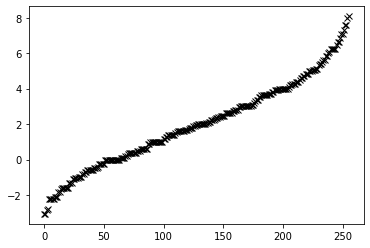

In [17]:
def ffh2(Gsqr,N,nq,dummy):
    dim= 2**nq
    HA=np.zeros((dim,dim)).astype(np.complex_)
    HB=np.zeros((dim,dim)).astype(np.complex_)
    Hfinal=np.zeros( (dim,dim)).astype(np.complex_)
    
    for i in range(N-1):
        HA = HA+ sigma_creator(nq,i,3) @ sigma_creator(nq,i+1,4)
        HA = HA - sigma_creator(nq,i+N,3) @ sigma_creator(nq,N+i+1,4)
        
        HA = HA +sigma_creator(nq,i,4) @ sigma_creator(nq,i+1,3)
        HA = HA -sigma_creator(nq,i+N,4) @ sigma_creator(nq,N+i+1,3)
                
        
        HB = HB + ( sigma_creator(nq,i,4) @ sigma_creator(nq,i,3) @  sigma_creator(nq,i+N,4) @ sigma_creator(nq,i+N,3) )
        
        
        
    HB = HB + (sigma_creator(nq,N-1,4) @ sigma_creator(nq,N-1,3) @ sigma_creator(nq,nq-1,4) @ sigma_creator(nq,nq-1,3) )

    
    Hfinal= dummy*HA+ Gsqr*HB
    
   
    
    temp=sparse.csr_matrix(Hfinal)
    print(temp)
    
    return Hfinal

#Create the Hamiltonian
Gsqr=2
N=4
nq=2*N # no of site
dummy=1
mmax=2**(nq) # each site has two qubit  

Hdum=ffh2(Gsqr,N,nq,dummy)
#Hdum=ffh(Gsqr,N,dummy)

#a,H_2site=ff2site(Gsqr,dummy)

#np.allclose(Hdum,H_2site)

four_fermi_eigenvalues, four_fermi_eigenvectors=sLA.eigh(Hdum)
['{:.2f}'.format(i) for i in four_fermi_eigenvalues]
plt.plot(four_fermi_eigenvalues,'xk')
#plt.plot(a,'^r')

# Eigenvector Validity Check

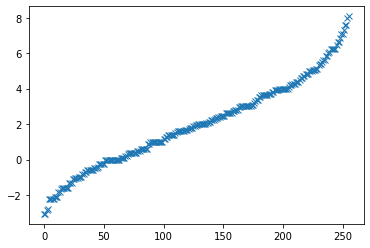

In [18]:
#spH=sparse.csr_matrix(Hdum)
#print(spH)
#spEV=sparse.csr_matrix(four_fermi_eigenvectors)
#print("EV")
#print(spEV)

#print("loop")
#Hdum.shape
#four_fermi_eigenvectors.shape

tag=-1
for i in range(len(Hdum)):
    for j in range(i+1,len(Hdum)):
        if np.iscomplex(Hdum[i][j]):
            tag=0
        if Hdum[i][j] != Hdum[j][i]:
            print("not symmetric",i,j,Hdum[i][j],Hdum[j][i])
            tag=0
    if tag==0:
        break
        
        
for i in range(len(four_fermi_eigenvalues)):
    assert np.allclose(Hdum @ four_fermi_eigenvectors[:,i] ,\
                four_fermi_eigenvalues[i]*four_fermi_eigenvectors[:,i],atol=1e-3), "eigenvectors not computed correctly"

plt.plot(four_fermi_eigenvalues,'x')
plt.show()
plt.close()

## Time evolution of quantum state
$|\psi(t)\rangle=\hat{U}(t) |\psi(0)\rangle = e^{-i \mathcal{H} t / \hbar} |\psi(0)\rangle
=e^{-i \mathcal{H} t / \hbar} \Big( \sum_j |\nu_j\rangle \langle \nu_j | \Big) |\psi(0)\rangle
= \sum_j \alpha_j e^{-i \lambda_j t / \hbar} | \nu_j \rangle
$

$\langle \psi(0)|\psi(t)\rangle
= \sum_j \alpha_j \alpha_k^* e^{-i \lambda_j t / \hbar}\langle \nu_k | \nu_j \rangle 
= \sum_j |\alpha_j|^2 e^{-i \lambda_j t / \hbar}
$

Eigenvalues of the Hamiltonian $\lambda_i$ and eigenvectors $|\nu_i\rangle$


Assuming convention:  

$$ |0\rangle = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$$ and $$ |1\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$.

Thus 
$$|00\rangle =\begin{bmatrix} 1 \\ 0 \end{bmatrix} \otimes \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 1 \\0\\0\\ 0 \end{bmatrix} $$ 


$\langle \psi(0)|\psi(t)\rangle
= \sum_j |\alpha_j|^2 (\cos(\lambda_j t ) -i \sin(\lambda_j t ) )
$

# Ground state: ladder form of Reiner _et._ _el._

Two chain of qubits. Upper chains are up spins, lower chains are down spins.

Zero state for a 2 site 4-qubit case:

$$ |1100\rangle =\begin{bmatrix} 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \end{bmatrix}
\otimes \begin{bmatrix} 1 \\ 0 \end{bmatrix}
\otimes \begin{bmatrix} 1 \\ 0 \end{bmatrix}
= \begin{bmatrix} 0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0 \end{bmatrix}^T $$

In [19]:
myzero = [1,0]   
myone = [0,1]  
SVarr_init=np.kron(np.kron(np.kron(myzero,myzero),myone),myone)
SVarr_init

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

256

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

0.2

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

loop
alpha_dagger_j alpha_j


Text(0, 0.5, '$|\\langle \\psi| \\mathrm{e}^{iHt} | \\psi \\rangle |^2 $')

Text(0.5, 0, '$t$')

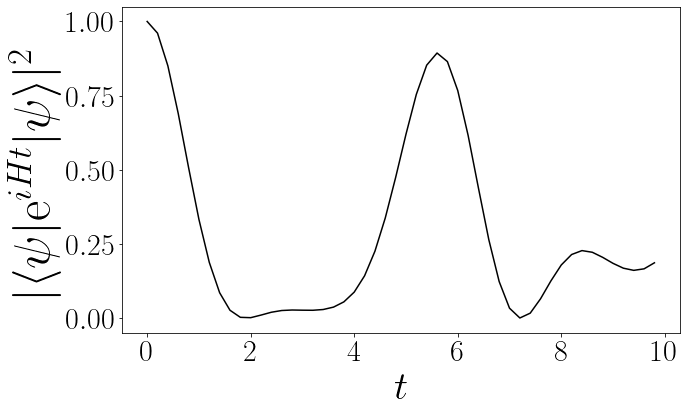

In [20]:
#four_fermi_eigenvectors
#for ind,i in enumerate( four_fermi_eigenvectors.T):
#   i
# create input state
mmax
instate=np.zeros(mmax,dtype=np.complex_) 
#|1000> state

inputstring="112"
instate[int(inputstring)]=1.0

instate

# number of time steps
totalT=10
nstep=50
#time step
delt=totalT/nstep
delt


alpha=np.zeros(mmax,dtype=np.complex_)
#projection to energy eigenstate
instate
print("loop")
for i in range( len(four_fermi_eigenvectors[0]) ):
    #four_fermi_eigenvectors[:,i]
    alpha[i]=four_fermi_eigenvectors[:,i] @ instate
    #alpha[i]

    
alpha_dagger=np.conjugate(alpha).T
coeffbase=np.multiply(alpha,alpha_dagger)
print("alpha_dagger_j alpha_j")

t=np.arange(0,nstep*delt,delt)
y=np.zeros(len(t))
coeff=np.zeros( len(t) ,dtype=np.complex_ )
for i in range(len(t)):
    coeff=np.inner(coeffbase,  np.exp(-1.0j*four_fermi_eigenvalues*t[i] ) )
    y[i]= np.abs(coeff)**2
    
    #coeff[i]
    
#y=[coeff*coeff  for i in range(len(t))]

plt.rc('text',usetex=True)
fig, ax = plt.subplots(facecolor='w',figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.plot(t,y,c='k' ) 
#plt.legend(loc='best',frameon=False,fontsize=25)
plt.ylabel(r'$|\langle \psi| \mathrm{e}^{iHt} | \psi \rangle |^2 $',fontsize=50)
plt.xlabel(r'$t$',fontsize=40)
plt.show()
plt.close()

In [21]:
instate

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

  (1, 2)	(-1+0j)
  (2, 1)	(-1+0j)
  (2, 4)	(-1+0j)
  (3, 5)	(-1+0j)
  (4, 2)	(-1+0j)
  (4, 8)	(-1+0j)
  (5, 3)	(-1+0j)
  (5, 6)	(-1+0j)
  (5, 9)	(-1+0j)
  (6, 5)	(-1+0j)
  (6, 10)	(-1+0j)
  (7, 11)	(-1+0j)
  (8, 4)	(-1+0j)
  (9, 5)	(-1+0j)
  (9, 10)	(-1+0j)
  (10, 6)	(-1+0j)
  (10, 9)	(-1+0j)
  (10, 12)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 13)	(-1+0j)
  (12, 10)	(-1+0j)
  (13, 11)	(-1+0j)
  (13, 14)	(-1+0j)
  (14, 13)	(-1+0j)
  (16, 32)	(1+0j)
  :	:
  (246, 245)	(-1+0j)
  (246, 246)	(4+0j)
  (246, 250)	(-1+0j)
  (247, 247)	(6+0j)
  (247, 251)	(-1+0j)
  (248, 244)	(-1+0j)
  (248, 248)	(2+0j)
  (249, 245)	(-1+0j)
  (249, 249)	(4+0j)
  (249, 250)	(-1+0j)
  (250, 246)	(-1+0j)
  (250, 249)	(-1+0j)
  (250, 250)	(4+0j)
  (250, 252)	(-1+0j)
  (251, 247)	(-1+0j)
  (251, 251)	(6+0j)
  (251, 253)	(-1+0j)
  (252, 250)	(-1+0j)
  (252, 252)	(4+0j)
  (253, 251)	(-1+0j)
  (253, 253)	(6+0j)
  (253, 254)	(-1+0j)
  (254, 253)	(-1+0j)
  (254, 254)	(6+0j)
  (255, 255)	(8+0j)


8

256

Text(0, 0.5, '$|\\langle \\psi| \\mathrm{e}^{iHt} | \\psi \\rangle |^2 $')

Text(0.5, 0, '$t$')

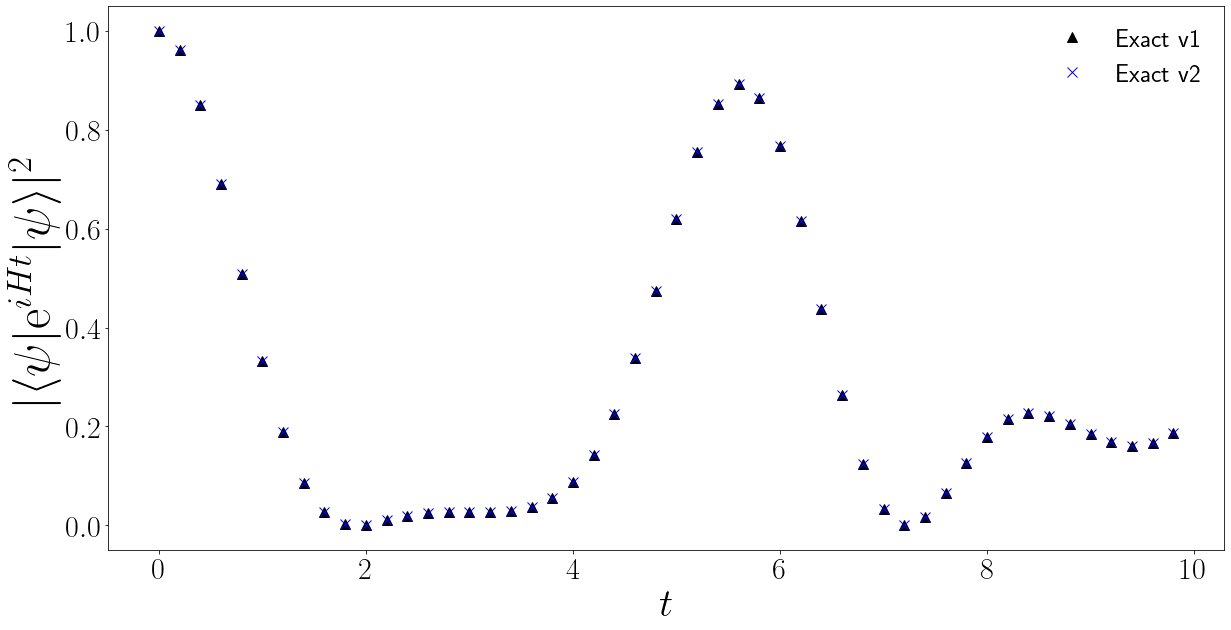

In [22]:
#ei=LA.eigh(ham(0.02,1.0,0))
ei=LA.eigh(ffh2(Gsqr,N,nq,1) )
#ei
nq
mmax
#evolution with correct complex conjugation    
def evol(tt):
    proj=np.zeros((mmax,mmax))+0.0+0.0j
    for uu in range(mmax):
        proj+=np.exp(-tt*1.0j*ei[0][uu])*np.outer(ei[1][:,uu],np.conjugate(ei[1][:,uu]))
        pass
    return proj



times1=np.zeros(nstep)
meas0=np.zeros(nstep)+0.0j  
meas1=np.zeros(nstep)+0.0j  
#going through all the time steps
for nst in range(nstep):
    #time
    tt=nst*delt
    times1[nst]=tt
    #evolution at time tt on instate
    wavet=np.dot(evol(tt),instate)
    #hermitian conjugate
    instatecc=np.conj(np.transpose(instate))
    
   # projstate0=np.dot(nnocc[0],wavet)
   # projstate1=np.dot(nnocc[1],wavet)
    meas0[nst]=(np.abs(np.inner(instatecc,wavet)))**2
    #meas1[nst]=np.inner(instatecc,projstate1)

plt.rc('text',usetex=True)
fig, ax = plt.subplots(facecolor='w',figsize=(20,10))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.plot(times1,np.real(meas0),'^k',ls='none',ms=10,label='Exact v1')
plt.plot(t,y,'xb',ms=10,label='Exact v2')
plt.legend(loc='best',frameon=False,fontsize=25)
plt.ylabel(r'$|\langle \psi| \mathrm{e}^{iHt} | \psi \rangle |^2 $',fontsize=50)
plt.xlabel(r'$t$',fontsize=40)
plt.show()
plt.close()

### Suzuki-Trotter approximation
First to fourth order 
$$
\begin{gathered}
e^{(A+B) t} \approx\left(e^{A t / n} e^{B t / n}\right)^{n}+O(t \Delta t) \\
e^{(A+B) t} \approx\left(e^{A t / 2 n} e^{B t / n} e^{A t / 2 n}\right)^{n}+O\left(t(\Delta t)^{2}\right) \\
e^{(A+B) t} \approx\left(e^{\frac{7}{24} A t / n} e^{\frac{2}{3} B t / n} e^{\frac{3}{4} A t / n} e^{\frac{-2}{3} B t / n} e^{\frac{-1}{24} A t / n} e^{B t / n}\right)^{n}+O\left(t(\Delta t)^{3}\right) \\
e^{(A+B) t} \approx\left(\prod_{i=1}^{5} e^{p_{i} A t / 2 n} e^{p_{i} B t / n} e^{p_{i} A t / 2 n}\right)^{n}+O\left(t(\Delta t)^{4}\right)
\end{gathered}
$$
where in the 4 th order equation, the constants are given by:
$$
p_{1}=p_{2}=p_{4}=p_{5}=\frac{1}{4-4^{1 / 3}}, \quad p_{3}=1-4 p_{1}
$$

  (1, 2)	(-1+0j)
  (2, 1)	(-1+0j)
  (2, 4)	(-1+0j)
  (3, 5)	(-1+0j)
  (4, 2)	(-1+0j)
  (4, 8)	(-1+0j)
  (5, 3)	(-1+0j)
  (5, 6)	(-1+0j)
  (5, 9)	(-1+0j)
  (6, 5)	(-1+0j)
  (6, 10)	(-1+0j)
  (7, 11)	(-1+0j)
  (8, 4)	(-1+0j)
  (9, 5)	(-1+0j)
  (9, 10)	(-1+0j)
  (10, 6)	(-1+0j)
  (10, 9)	(-1+0j)
  (10, 12)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 13)	(-1+0j)
  (12, 10)	(-1+0j)
  (13, 11)	(-1+0j)
  (13, 14)	(-1+0j)
  (14, 13)	(-1+0j)
  (16, 32)	(1+0j)
  :	:
  (239, 223)	(1+0j)
  (241, 242)	(-1+0j)
  (242, 241)	(-1+0j)
  (242, 244)	(-1+0j)
  (243, 245)	(-1+0j)
  (244, 242)	(-1+0j)
  (244, 248)	(-1+0j)
  (245, 243)	(-1+0j)
  (245, 246)	(-1+0j)
  (245, 249)	(-1+0j)
  (246, 245)	(-1+0j)
  (246, 250)	(-1+0j)
  (247, 251)	(-1+0j)
  (248, 244)	(-1+0j)
  (249, 245)	(-1+0j)
  (249, 250)	(-1+0j)
  (250, 246)	(-1+0j)
  (250, 249)	(-1+0j)
  (250, 252)	(-1+0j)
  (251, 247)	(-1+0j)
  (251, 253)	(-1+0j)
  (252, 250)	(-1+0j)
  (253, 251)	(-1+0j)
  (253, 254)	(-1+0j)
  (254, 253)	(-1+0j)
  (17, 17)	(2+0j)
  (19, 1

Text(0, 0.5, '$|\\langle \\psi|\\mathrm{e}^{iHt} | \\psi \\rangle |^2 $')

Text(0.5, 0, '$t$')

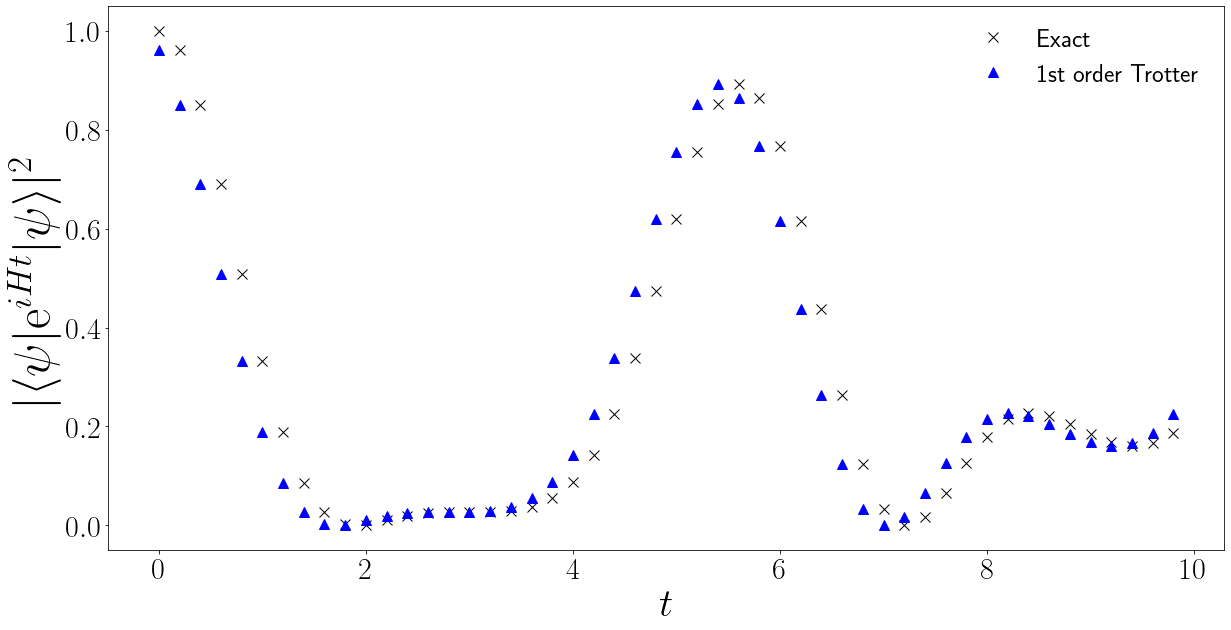

In [23]:
# First Order Trotter version


ei1=LA.eigh(ffh2(0,N,nq,1) )
#evolution with INcorrect complex conjugation    
def evol1(tt):
    proj=np.zeros((mmax,mmax))+0.0+0.0j
    for uu in range(mmax):
        proj+=np.exp(-tt*1.0j*ei1[0][uu])*np.outer(np.conjugate(ei1[1][:,uu]),ei1[1][:,uu])
        pass
    return proj

ei2=LA.eigh(ffh2(Gsqr,N,nq,0) )
#evolution with INcorrect complex conjugation    
def evol2(tt):
    proj=np.zeros((mmax,mmax))+0.0+0.0j
    for uu in range(mmax):
        proj+=np.exp(-tt*1.0j*ei2[0][uu])*np.outer(np.conjugate(ei2[1][:,uu]),ei2[1][:,uu])
        pass
    return proj

trotstep=np.matmul(evol1(delt),evol2(delt))
times2=np.zeros(nstep)
meas2=np.zeros(nstep)+0.0j  
#going through all the Trotter steps



wavet=instate
instatecc=np.conj(np.transpose(wavet))
for nst in range(nstep):
    #time
    tt=nst*delt
    times2[nst]=tt
    
    #projstate=np.dot(nnocc[0],wavet)
    #meas2[nst]=np.inner(instatecc,projstate)
    
    #evolution at time tt on instate
    wavet=np.dot(trotstep,wavet)
    meas2[nst]=(np.abs(np.inner(instatecc,wavet)))**2


#plt.figure(figsize=(2.5,3))
plt.rc('text',usetex=True)
fig, ax = plt.subplots(facecolor='w',figsize=(20,10))
ax.tick_params(axis='both', which='major', labelsize=30)
plt.plot(times1,np.real(meas0),'xk',ms=10,label='Exact')
plt.plot(times2,np.real(meas2),'^b',ms=10,label='1st order Trotter')
plt.legend(loc='best',frameon=False,fontsize=25)
plt.ylabel(r'$|\langle \psi|\mathrm{e}^{iHt} | \psi \rangle |^2 $',fontsize=50)
plt.xlabel(r'$t$',fontsize=40)
plt.show()
plt.close()
#instate

  (1, 2)	(-0.5+0j)
  (2, 1)	(-0.5+0j)
  (2, 4)	(-0.5+0j)
  (3, 5)	(-0.5+0j)
  (4, 2)	(-0.5+0j)
  (4, 8)	(-0.5+0j)
  (5, 3)	(-0.5+0j)
  (5, 6)	(-0.5+0j)
  (5, 9)	(-0.5+0j)
  (6, 5)	(-0.5+0j)
  (6, 10)	(-0.5+0j)
  (7, 11)	(-0.5+0j)
  (8, 4)	(-0.5+0j)
  (9, 5)	(-0.5+0j)
  (9, 10)	(-0.5+0j)
  (10, 6)	(-0.5+0j)
  (10, 9)	(-0.5+0j)
  (10, 12)	(-0.5+0j)
  (11, 7)	(-0.5+0j)
  (11, 13)	(-0.5+0j)
  (12, 10)	(-0.5+0j)
  (13, 11)	(-0.5+0j)
  (13, 14)	(-0.5+0j)
  (14, 13)	(-0.5+0j)
  (16, 32)	(0.5+0j)
  :	:
  (239, 223)	(0.5+0j)
  (241, 242)	(-0.5+0j)
  (242, 241)	(-0.5+0j)
  (242, 244)	(-0.5+0j)
  (243, 245)	(-0.5+0j)
  (244, 242)	(-0.5+0j)
  (244, 248)	(-0.5+0j)
  (245, 243)	(-0.5+0j)
  (245, 246)	(-0.5+0j)
  (245, 249)	(-0.5+0j)
  (246, 245)	(-0.5+0j)
  (246, 250)	(-0.5+0j)
  (247, 251)	(-0.5+0j)
  (248, 244)	(-0.5+0j)
  (249, 245)	(-0.5+0j)
  (249, 250)	(-0.5+0j)
  (250, 246)	(-0.5+0j)
  (250, 249)	(-0.5+0j)
  (250, 252)	(-0.5+0j)
  (251, 247)	(-0.5+0j)
  (251, 253)	(-0.5+0j)
  (252, 250)	(-0.5

Text(0, 0.5, '$|\\langle \\psi| \\mathrm{e}^{iHt}  | \\psi \\rangle |^2 $')

Text(0.5, 0, '$t$')

Text(0.13, 0.9, '$L$=4')

Text(0.13, 0.8, '$Q$=8')

Text(0.13, 0.7, '$G^2$=2.0')

Text(0.13, 0.6, '$\\delta t$=0.20')

TypeError: can only concatenate str (not "int") to str

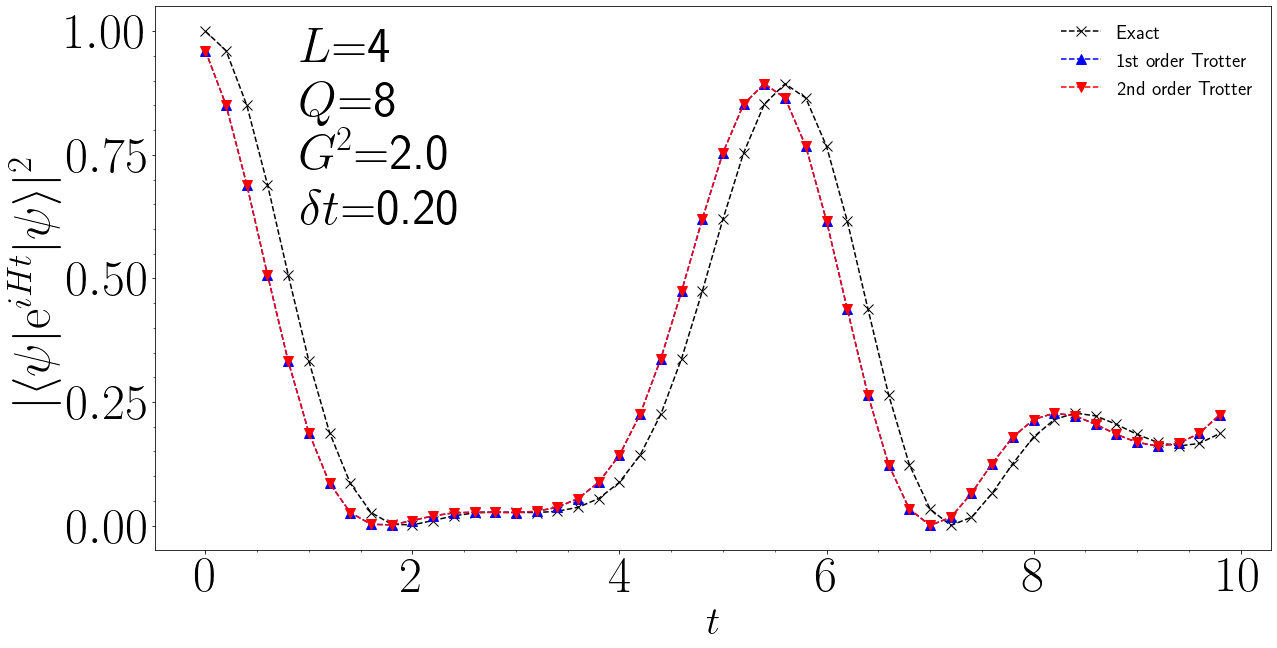

In [24]:
ei1=LA.eigh(ffh2(0,N,nq,0.5) )
#evolution with INcorrect complex conjugation    
def evol1(tt):
    proj=np.zeros((mmax,mmax))+0.0+0.0j
    for uu in range(mmax):
        proj+=np.exp(-tt*1.0j*ei1[0][uu])*np.outer(np.conjugate(ei1[1][:,uu]),ei1[1][:,uu])
        pass
    return proj
ei2=LA.eigh(ffh2(Gsqr,N,nq,0) )
#evolution with INcorrect complex conjugation    
def evol2(tt):
    proj=np.zeros((mmax,mmax))+0.0+0.0j
    for uu in range(mmax):
        proj+=np.exp(-tt*1.0j*ei2[0][uu])*np.outer(np.conjugate(ei2[1][:,uu]),ei2[1][:,uu])
        pass
    return proj
trotstep=np.matmul(np.matmul(evol1(delt),evol2(delt)),evol1(delt))
times2=np.zeros(nstep)
meas3=np.zeros(nstep)+0.0j  
#going through all the Trotter steps

wavet=instate
instatecc=np.conj(np.transpose(wavet))
for nst in range(nstep):
    #time
    tt=nst*delt
    times2[nst]=tt
    
    #projstate=np.dot(nnocc[0],wavet)
    #meas2[nst]=np.inner(instatecc,projstate)
    
    #evolution at time tt on instate
    wavet=np.dot(trotstep,wavet)
    meas3[nst]=(np.abs(np.inner(instatecc,wavet)))**2

plt.rc('text',usetex=True)
fig, ax = plt.subplots(facecolor='w',figsize=(20,10))
ax.tick_params(axis='both', which='major', labelsize=50)
ax.minorticks_on()
#plt.figure(figsize=(20,10),facecolor="w")
plt.plot(times1,np.real(meas0),'xk', ls='--',ms=10,label='Exact')
plt.plot(times2,np.real(meas2),'^b',ls='--',ms=10,label='1st order Trotter')
plt.plot(times2,np.real(meas3),'vr',ls='--',ms=10,label='2nd order Trotter')
plt.legend(loc='best',frameon=False,fontsize=20)
plt.ylabel(r'$|\langle \psi| \mathrm{e}^{iHt}  | \psi \rangle |^2 $',fontsize=50)
plt.xlabel(r'$t$',fontsize=40)
plt.annotate(r'$L$=%d'%N , xy=(0.13, 0.9), xycoords='axes fraction',fontsize=50)
plt.annotate(r'$Q$=%d'%nq , xy=(0.13, 0.8), xycoords='axes fraction',fontsize=50)
plt.annotate(r'$G^2$=%0.1f'%Gsqr , xy=(0.13, 0.7), xycoords='axes fraction',fontsize=50)
plt.annotate(r'$\delta t$=%0.2f'%delt , xy=(0.13, 0.6), xycoords='axes fraction',fontsize=50)
#plt.plot(times2,np.real(meas2-meas1))
plt.savefig("L"+N+".classical."+inputstring+".png",bbox_inches='tight')
plt.show()
plt.close()


In [26]:
delt
for i in range(len(times1)):
    print("%0.2f      %0.2f" %(times1[i],np.real(meas2)[i]) )

df=pd.DataFrame(np.array([times1,np.real(meas0)]).T )
df.to_csv("L"+str(N)+"_data_exact_"+inputstring,sep='\t',index=False,header=None)

df=pd.DataFrame(np.array([times1,np.real(meas2)]).T )
df.to_csv("L"+str(N)+"_data_Trotter_"+inputstring,sep='\t',index=False,header=None)

0.2

0.00      0.96
0.20      0.85
0.40      0.69
0.60      0.51
0.80      0.33
1.00      0.19
1.20      0.09
1.40      0.03
1.60      0.00
1.80      0.00
2.00      0.01
2.20      0.02
2.40      0.03
2.60      0.03
2.80      0.03
3.00      0.03
3.20      0.03
3.40      0.04
3.60      0.05
3.80      0.09
4.00      0.14
4.20      0.23
4.40      0.34
4.60      0.47
4.80      0.62
5.00      0.75
5.20      0.85
5.40      0.89
5.60      0.86
5.80      0.77
6.00      0.62
6.20      0.44
6.40      0.26
6.60      0.12
6.80      0.03
7.00      0.00
7.20      0.02
7.40      0.07
7.60      0.13
7.80      0.18
8.00      0.21
8.20      0.23
8.40      0.22
8.60      0.20
8.80      0.18
9.00      0.17
9.20      0.16
9.40      0.17
9.60      0.19
9.80      0.22


# EPFL application Hamiltonian

$H= \sigma_z (0) \sigma_z (1) -\sigma_y (1) \sigma_y (2) -\sigma_x (2) \sigma_x (0)$

In [ ]:
EPFL_H= sigma_creator(3,0,2) @ sigma_creator(3,1,2) -sigma_creator(3,1,1) @ sigma_creator(3,2,1) -sigma_creator(3,2,0) @ sigma_creator(3,0,0)

x,y=sLA.eigh(EPFL_H)
x
np.min(x)*np.max(x)

plt.plot(x,'xk')
plt.show()